In [1]:
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import ElasticNet,Lasso,Ridge,LinearRegression,ElasticNetCV,LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 1. write the equation that governs the SRE
# M - 2M (1 / (1 + exp((a * x)^b)))

In [2]:
def single_sre(a,b,m,cycles):
        try:
            sre = []
            for cycle in cycles:
                z = 1 + math.exp((a * cycle)**b)
                f = m - ((2* m) * (1/z))
                sre.append(f)
            return sre
        except OverflowError:
            z = float('inf')
            return z

In [3]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

In [4]:
def r2(actual,predicted):
    df = pd.DataFrame({'actual':actual,'predicted':predicted})
    SS_tot = sum((df['actual']-df['actual'].mean())**2)
    SS_reg = sum((df['actual']-df['predicted'])**2)
    return(1-SS_reg/SS_tot)

In [5]:
def expandgrid(a,b):
    product = list(itertools.product(list(np.ravel(a)),
                                     list(np.ravel(b))))
    df = pd.DataFrame(product,columns=['a','b'])
    return df

# 2. create a range of values for a, b, and m

In [6]:
num_a = 100
num_b = 1
a_range = np.linspace(.02, .03,num_a)
# b_range = 0.6
#b_range = seq(.5, .7, length.out = num_b)
b_range = np.linspace(0.5,0.7,num_b)
m_range = 20.5 # fixed

In [7]:
all_combinations = expandgrid(a_range,b_range)
num_combinations = all_combinations.shape[0]

- estiamted SRE through cell sage: a = 0.0219, b = 0.600, m = 20.5

# 3. Create the data required for regression
- read in the data

In [8]:
cells = pd.read_excel('./cells.xlsx')
response4 = cells[cells['cell']==4]
response5 = cells[cells['cell']==5]
response6 = cells[cells['cell']==6]
response16 = cells[cells['cell']==16]

- create data required for elastic net as a 
- series of different potential values of a, b, and m

In [9]:
def modeling(response,num_combinations,all_combinations):
    cycles = response['cycles']
    capacity = response['capacity']
    num_cycles = len(cycles)
    pred_matrix = np.zeros((num_cycles,num_combinations))
    for i in range(num_combinations):
        pred_matrix[:,i] = single_sre(cycles=cycles,
                                  a=all_combinations['a'][i], 
                                  b=all_combinations['b'][i],
                                  m=m_range)
    metrics = {}
    ############# Elastic Net Regression Analysis ################
    print("Starting the Regression Analysis with Elastic Net Regression with alpha as 0.5")
    print("="*125)
    enet = ElasticNetCV(l1_ratio=0.5)
    fit = enet.fit(X=pred_matrix,y=capacity)
    
    temp_lambda = fit.alphas_
    new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[3]),100)]
    enet = ElasticNetCV(l1_ratio=0.5,alphas=new_lambda)
    fit = enet.fit(X=pred_matrix,y=capacity)
    
    lm = LinearRegression()
    fit = lm.fit(X=pred_matrix[:,20:21],y=np.array(capacity).reshape(-1,1))
    
    pred_val = fit.predict(pred_matrix[:,20:21])
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"Elastic Net":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    
    print("End of Elastic Net Regression with alpha as 0.5")
    print("="*125,'\n')
    
    ################ Adaptive Lasso ################
    
    print("Starting the Regression Analysis with Adaptive Lasso Regression with alpha as 0")
    print("="*125)
    enet = ElasticNetCV(l1_ratio=0,alphas=np.arange(0,1,0.2))
    fit = enet.fit(pred_matrix,capacity)
    temp_coefs = fit.coef_
    enet = ElasticNetCV(l1_ratio=1/abs(min(temp_coefs)))
    fit = enet.fit(pred_matrix,capacity)
    
    pred_val = fit.predict(pred_matrix)
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("Adaptive Lasso")
    plt.plot(pred_val,'r')
    plt.show()
    
    fit = lm.fit(X=pred_matrix[:,1:2],y=np.array(capacity).reshape(-1,1))
    pred_val = fit.predict(pred_matrix[:,1:2])
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("Adaptive Lasso LR")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"Adaptive Lasso":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    print("End of Adaptive Lasso Regression with alpha as 0")
    print("="*125,'\n')
    
    ############ LASSO ###########
    
    print("Starting the Regression Analysis with Lasso Regression with alpha as 1")
    print("="*125)
    enet = ElasticNetCV(l1_ratio=1)
    fit = enet.fit(pred_matrix,capacity)
    temp_lambda = fit.alphas_
    new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[5]),100)]
    enet = ElasticNetCV(l1_ratio=1,alphas=new_lambda)
    
    fit = enet.fit(pred_matrix,capacity)
    fit = lm.fit(X=pred_matrix[:,18:19],y=np.array(capacity).reshape(-1,1))
    
    pred_val = fit.predict(pred_matrix[:,18:19])
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("LASSO")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"Lasso":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    
    print("End of Adaptive Lasso Regression with alpha as 1")
    print("="*125,'\n')
    
    ############### SCAD ###############
    
    print("Starting the Regression Analysis with SCAD Regression with alpha as 3.7")
    print("="*125)
    
    enet= ElasticNetCV(l1_ratio=3.7)
    fit = enet.fit(pred_matrix,capacity)
    
    pred_val = fit.predict(pred_matrix)
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("SCAD full data")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"SCAD Full Data":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    print("End of SCAD Regression with alpha as 3.7")
    print("="*125,'\n')
    
    ############## SCAD with 12th Column ############
    print("Starting the Regression Analysis with SCAD Regression for 12th Column")
    print("="*125)
    fit = lm.fit(X=pred_matrix[:,12:13],y=np.array(capacity).reshape(-1,1))
    pred_val = fit.predict(pred_matrix[:,12:13])
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("SCAD 12th Column")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"SCAD 12th Column":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    print("End of SCAD Regression for 12th Column")
    print("="*125,'\n')
    
    ############# SCAD with 20th Column #############
    print("Starting the Regression Analysis with SCAD Regression for 30th Column")
    print("="*125)
    fit = lm.fit(X=pred_matrix[:,20:21],y=np.array(capacity).reshape(-1,1))
    pred_val = fit.predict(pred_matrix[:,30:31])
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(capacity))),y=capacity)
    plt.title("SCAD with 20th Column")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"SCAD 30th Column":[
                rmse(x=capacity,y=pred_val),
                r2(capacity,pred_val.reshape(-1,))
    ]})
    print("End of SCAD Regression for 30th Column")
    print("="*125,'\n')
    ################ SRE Solve ###############
    
    # normalized capacity

    norm_capacity = capacity
    m = max(norm_capacity)
    norm_capacity =(norm_capacity - m )/ (- 2 * m)
    plt.plot(norm_capacity)
    plt.title("Norm Capacity")
    plt.show()
    
    b_range = np.linspace(0.4,0.7,100)
    b_matrix = np.zeros([len(response['cycles']),len(b_range)])
    for i in range(len(b_range)):
        b_matrix[:,i] = response['cycles']**b_range[i]
        
    print("Starting the Regression Analysis with Elastic Net Regression with alpha 0.5 for Norm_Capacity")
    print("="*125)
    enet = ElasticNetCV(l1_ratio=0.5)
    fit = enet.fit(b_matrix,norm_capacity)  
    pred_val = fit.predict(b_matrix)
    plt.figure(figsize=(10,4))
    plt.scatter(x=list(range(len(norm_capacity))),y=norm_capacity)
    plt.title("Elastic Net with Normalized Capacity")
    plt.plot(pred_val,'r')
    plt.show()
    
    metrics.update({"Elastic Net with Norm Capacity":[
                rmse(x=norm_capacity,y=pred_val),
                r2(norm_capacity,pred_val.reshape(-1,))
    ]})
    print("End of Elastic Net Regression for Norm_Capacity")
    print("="*125,'\n')
    
    ############### Metrics Dataframe ###############
    
    df = pd.DataFrame()
    df['Model Metrics'] = metrics.keys()
    df['RMSE'] = [i[0] for i in list(metrics.values())]
    df['RSquared'] = [i[1] for i in list(metrics.values())]

    return df

Starting the Regression Analysis with Elastic Net Regression with alpha as 0.5


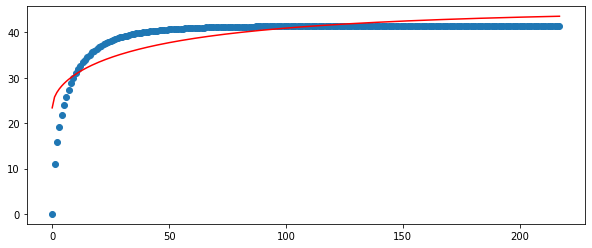

End of Elastic Net Regression with alpha as 0.5

Starting the Regression Analysis with Adaptive Lasso Regression with alpha as 0


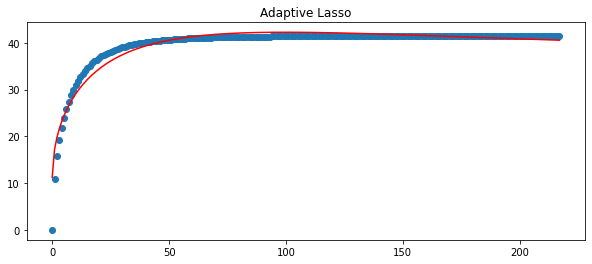

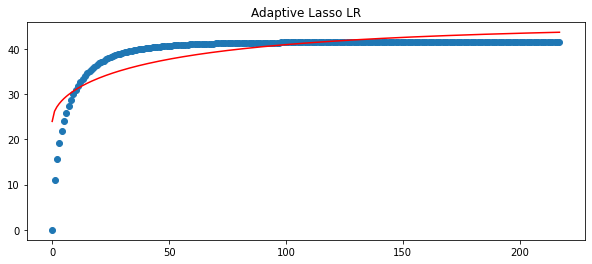

End of Adaptive Lasso Regression with alpha as 0

Starting the Regression Analysis with Lasso Regression with alpha as 1


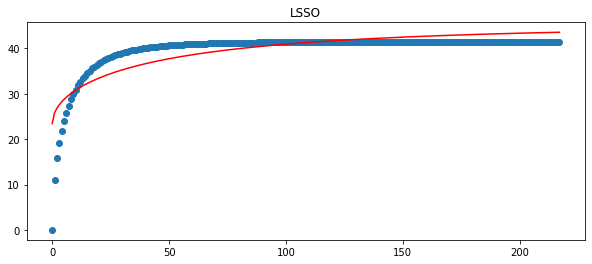

End of Adaptive Lasso Regression with alpha as 1

Starting the Regression Analysis with SCAD Regression with alpha as 3.7


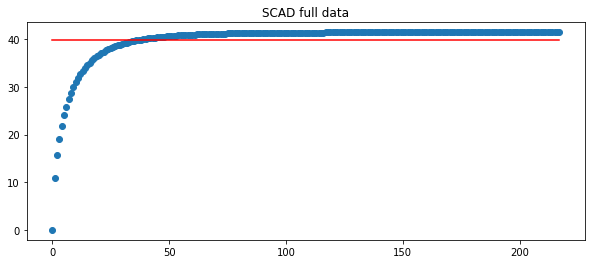

End of SCAD Regression with alpha as 3.7

Starting the Regression Analysis with SCAD Regression for 12th Column


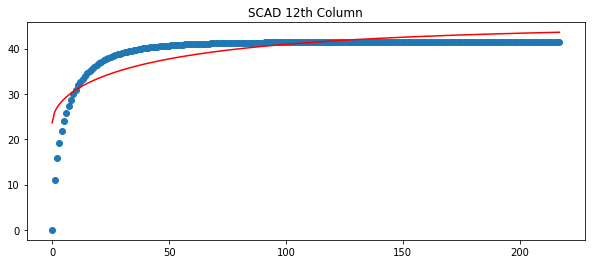

End of SCAD Regression for 12th Column

Starting the Regression Analysis with SCAD Regression for 30th Column


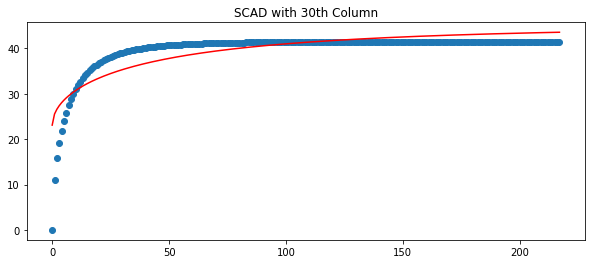

End of SCAD Regression for 30th Column



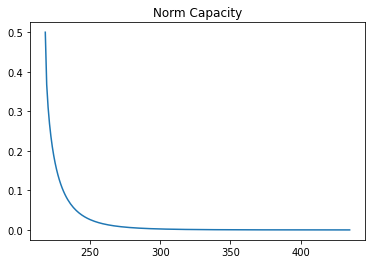

Starting the Regression Analysis with Elastic Net Regression with alpha 0.5 for Norm_Capacity


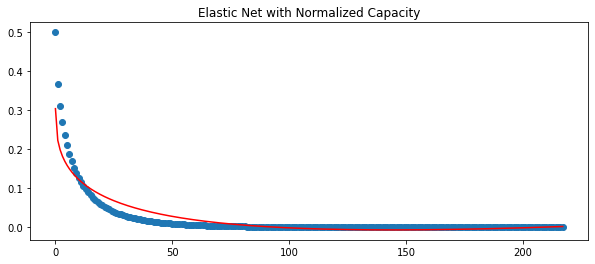

End of Elastic Net Regression for Norm_Capacity



,Model Metrics,RMSE,RSquared
0,Elastic Net,2.879745,6.636714e-01
1,Adaptive Lasso,2.945671,6.480958e-01
2,Lasso,2.886620,6.620636e-01
3,SCAD Full Data,4.965604,-2.220446e-16
4,SCAD 12th Column,2.907336,6.571957e-01
5,SCAD 30th Column,2.845591,6.716018e-01
6,Elastic Net with Norm Capacity,0.023216,8.495855e-01


In [10]:
modeling(response=response5,num_combinations=num_combinations,all_combinations=all_combinations)

Starting the Regression Analysis with Elastic Net Regression with alpha as 0.5


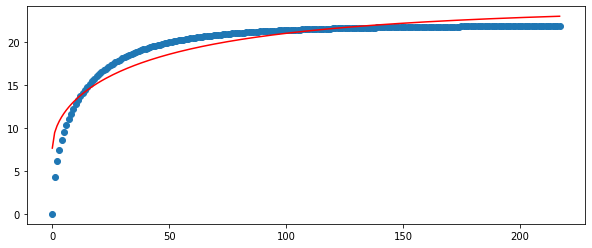

End of Elastic Net Regression with alpha as 0.5

Starting the Regression Analysis with Adaptive Lasso Regression with alpha as 0


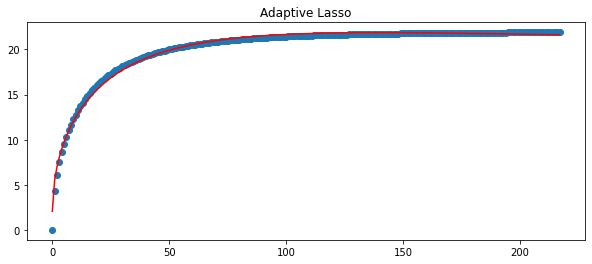

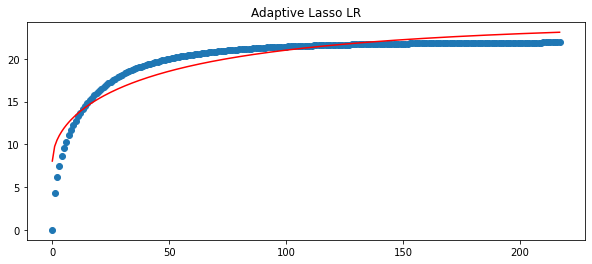

End of Adaptive Lasso Regression with alpha as 0

Starting the Regression Analysis with Lasso Regression with alpha as 1


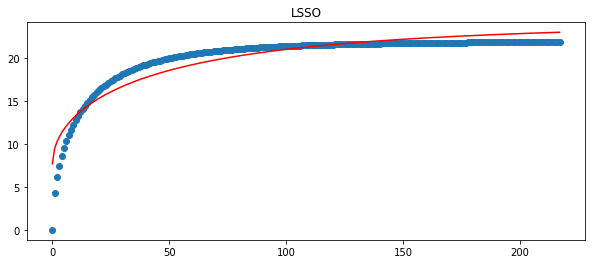

End of Adaptive Lasso Regression with alpha as 1

Starting the Regression Analysis with SCAD Regression with alpha as 3.7


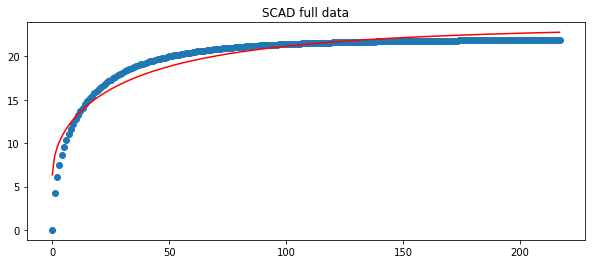

End of SCAD Regression with alpha as 3.7

Starting the Regression Analysis with SCAD Regression for 12th Column


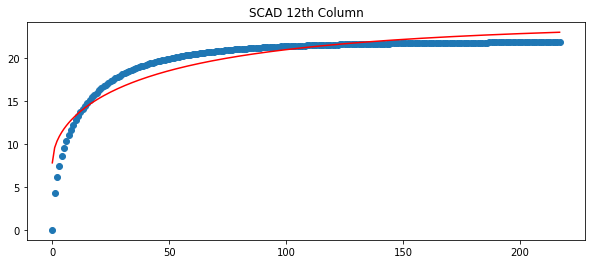

End of SCAD Regression for 12th Column

Starting the Regression Analysis with SCAD Regression for 30th Column


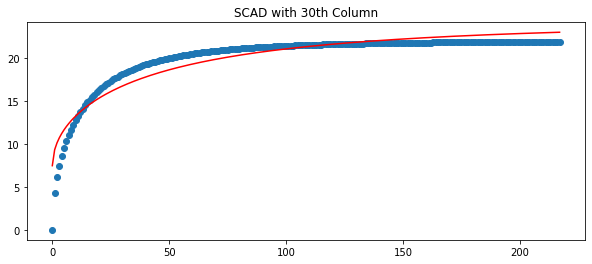

End of SCAD Regression for 30th Column



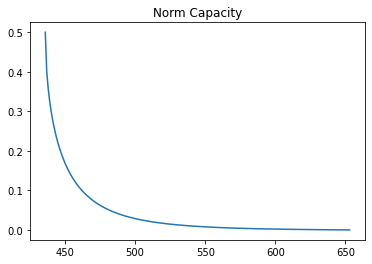

Starting the Regression Analysis with Elastic Net Regression with alpha 0.5 for Norm_Capacity


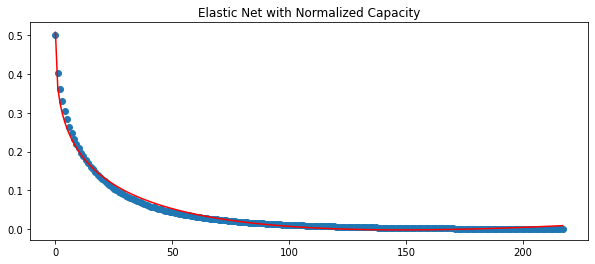

End of Elastic Net Regression for Norm_Capacity



,Model Metrics,RMSE,RSquared
0,Elastic Net,1.153547,0.876852
1,Adaptive Lasso,1.208480,0.864844
2,Lasso,1.159254,0.875630
3,SCAD Full Data,0.944158,0.917501
4,SCAD 12th Column,1.176480,0.871907
5,SCAD 30th Column,1.125273,0.882815
6,Elastic Net with Norm Capacity,0.007999,0.988635


In [11]:
modeling(response=response6,num_combinations=num_combinations,all_combinations=all_combinations)

Starting the Regression Analysis with Elastic Net Regression with alpha as 0.5


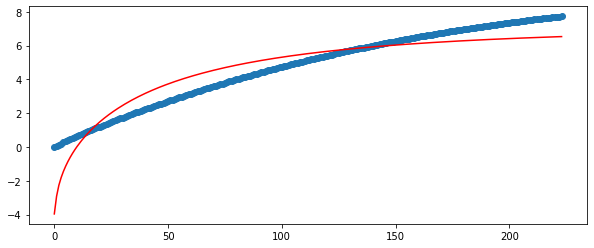

End of Elastic Net Regression with alpha as 0.5

Starting the Regression Analysis with Adaptive Lasso Regression with alpha as 0


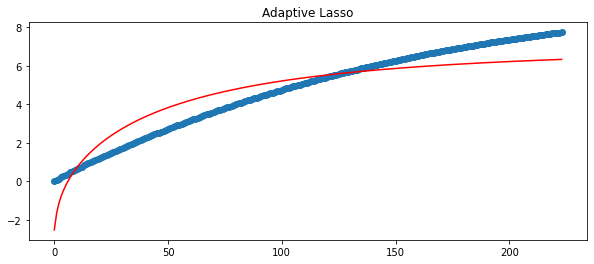

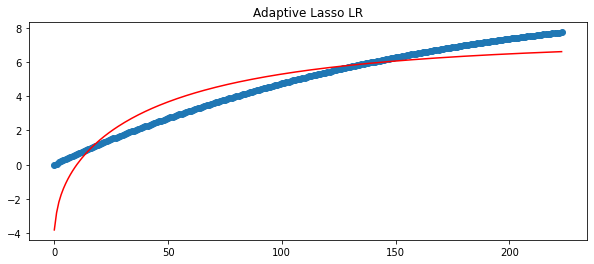

End of Adaptive Lasso Regression with alpha as 0

Starting the Regression Analysis with Lasso Regression with alpha as 1


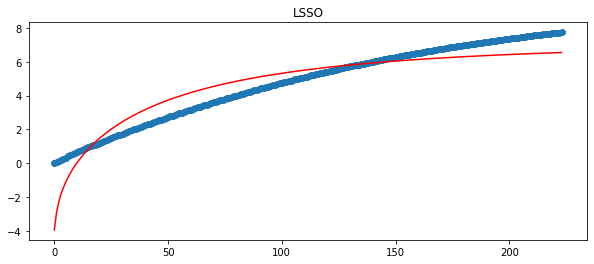

End of Adaptive Lasso Regression with alpha as 1

Starting the Regression Analysis with SCAD Regression with alpha as 3.7


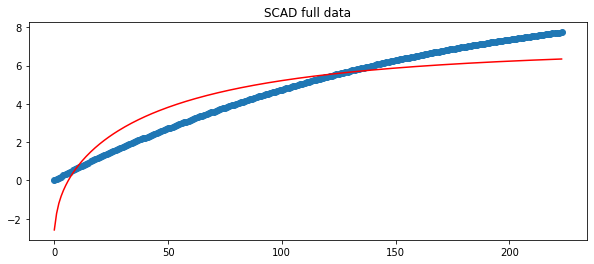

End of SCAD Regression with alpha as 3.7

Starting the Regression Analysis with SCAD Regression for 12th Column


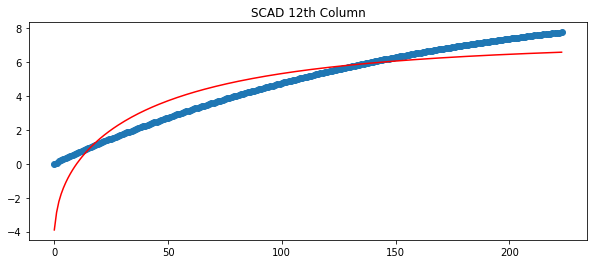

End of SCAD Regression for 12th Column

Starting the Regression Analysis with SCAD Regression for 30th Column


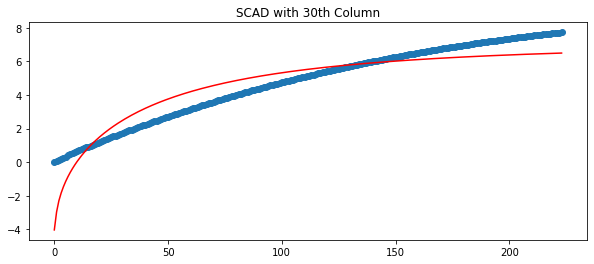

End of SCAD Regression for 30th Column



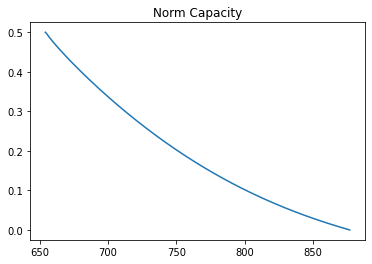

Starting the Regression Analysis with Elastic Net Regression with alpha 0.5 for Norm_Capacity


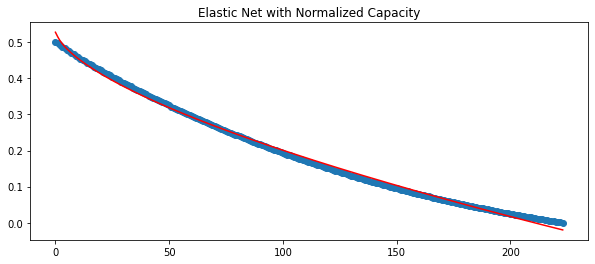

End of Elastic Net Regression for Norm_Capacity



,Model Metrics,RMSE,RSquared
0,Elastic Net,0.829929,0.860275
1,Adaptive Lasso,0.787609,0.874162
2,Lasso,0.825583,0.861735
3,SCAD Full Data,0.839258,0.857116
4,SCAD 12th Column,0.812394,0.866117
5,SCAD 30th Column,0.851288,0.852991
6,Elastic Net with Norm Capacity,0.008336,0.996623


In [12]:
modeling(response=response16,num_combinations=num_combinations,all_combinations=all_combinations)